# Introducción problemas de clasificación.

En el tema anterior hemos visto cómo poder utilizar Pytorch para poder resolver problemas de regresión donde la variable de respuesta es una variable de tipo continuo que puede tomar una infinidad de valores. Lógicamente este modelo no nos sirve cuando estamos en presencia de un modelo de clasificación ya que en estos casos, la variable dependiente va a tomar dos valores (clasificación binaria) o bien un escaso numero de valores.

Lo primero que haremos será cargar las librerías que van a ser necesarias para el desarrollo de este capítulo.

In [18]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, \
precision_recall_curve, auc

In [19]:
from stepbystep.v0 import StepByStep

Para desarrollar este trabajo vamos a suponer que la variables dependiente puede tomar sólo dos valores, o lo que es lo mismos, tiene dos clases:rojo o azul. Vamos a cambiar estos valores, de tal manera que al rojo le reasignamos el valor de 0 y al azul el valor de 1. Los valores cero diremos que son de la clase negativa y los valores de 1 de la clase positiva.

:::{note}
En un modelo de clasificación binaria, lo que vamos a obtener es la probabilidad de pertenecer a la clase positiva, es decir, en este ejemplo de predecir que se trata de la clase azul.
:::

## Generación de los datos.

En este caso vamos a avanzar un poco en relación con las features con las que vamos a trabajar y suponemos que en este caso son dos features o variables independientes que vamos a designar por x1 y x2. Además nos vamos a valer de la clase de scikit-learn *make_moons* para generar un total de 100 puntos. Además de esto vamos a añadir un ruido gaussino. Lo hacemos con la siguiente instrucción.

In [20]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

A continuación vamos a ver que X es un numpy array de dimensión 100x2 e y es otro arra de dimensión 100x1

In [21]:
print("X es un objeto de tipo: ",type(X))
print("La dimensión de X es: ",X.shape)

X es un objeto de tipo:  <class 'numpy.ndarray'>
La dimensión de X es:  (100, 2)


In [22]:
print("y es un objeto de tipo: ",type(y))
print("La dimensión de y es: ",y.shape)

y es un objeto de tipo:  <class 'numpy.ndarray'>
La dimensión de y es:  (100,)


Generamos los datos de entrenamiento y de test utilizando la siguiente instrucción de scikit-learn

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
X,
y,
test_size=.2,
random_state=13
)

Además en los problemas de redes neuronales, conviene estandarizar las features, esto lo hacemos apoyándonos en scikit-learn.

In [24]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def figure1(X_train, y_train, X_val, y_val, cm_bright=None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)#, edgecolors='k')
    ax[0].set_xlabel(r'$X_1$')
    ax[0].set_ylabel(r'$X_2$')
    ax[0].set_xlim([-2.3, 2.3])
    ax[0].set_ylim([-2.3, 2.3])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright)#, edgecolors='k')
    ax[1].set_xlabel(r'$X_1$')
    ax[1].set_ylabel(r'$X_2$')
    ax[1].set_xlim([-2.3, 2.3])
    ax[1].set_ylim([-2.3, 2.3])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()
    
    return fig

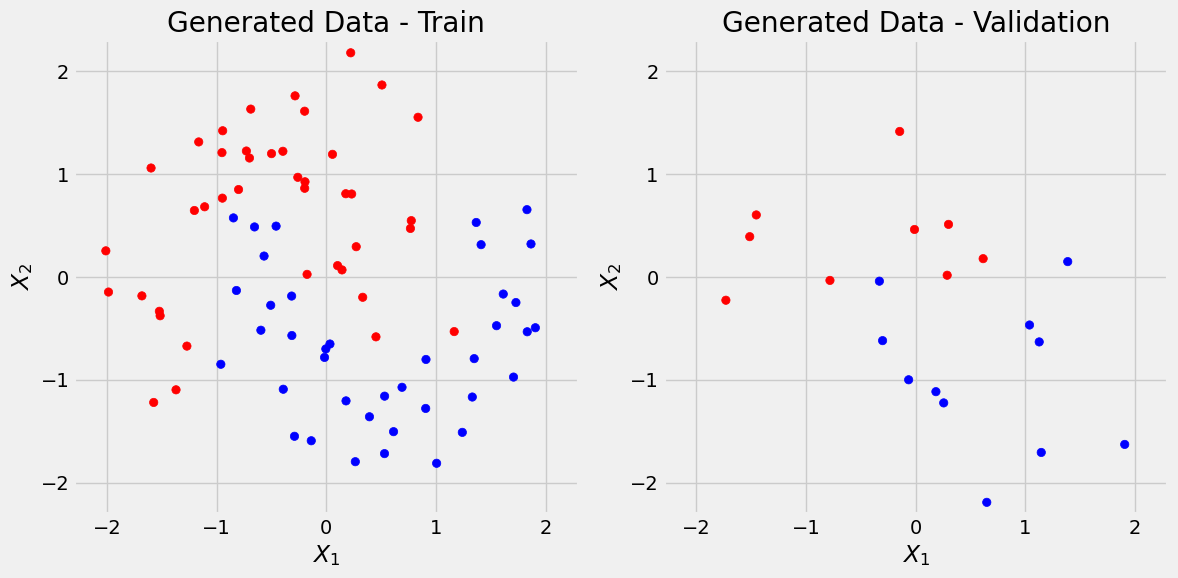

In [26]:
fig = figure1(X_train, y_train, X_val, y_val)

## Preparación de los datos.

Vamos a proceder a preparar los datos de una forma muy similar a como lo hemos hecho para el análisis de regresión. 

Antes de seguir adelante conviene subrayar el formato de los datos con los que vamos a trabajar. En concreto X_train y X_val son matrices de dimensiones (?,2),(donde el signo ? indica el número de filas que tiene) pero no ocurre así con la variables que nos indica la clasificación. En efecto, veamoslo para y_train

In [27]:
y_train.shape

(80,)

Como podemos ver es un vector fila, pero lo tenemos que pasar a vector columna (como con y_val). Esto lo hacemos con el método .reshape(-1,1). Observar esto en el código que implementamos a continuación.

In [28]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
# ¡¡¡ OJO con este reshape que tenemos que hacer !!!!!!!!!!
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## El modelo.

Vamos a explicar en este apartado en qué consiste el modelo de regresión logit, para ello vamos a partir de un modelo de regresión que ya todos conocemos.

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

Lo primero que debemos de tener en cuenta con este modelo es que no nos sirve para resolver el problema que tenemos, ya que la variable según este modelo puede tener una infinidad de valores, pero sin embargo en nuestro caso sólo tiene los valores cero o uno, en consecuencia debemos reformularlo para poderlo utilizar en este problema.

Entonces la reformulación que podemos hacer puede ser la siguiente:

$$
\Large 
y =
\begin{cases}
1,\ \text{si }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{si }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

```{index} odds ratio
```
Para reformular mejor este problema, vamos a definir las *odds ratio*  de la siguiente manera

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

Con poco código Python podemos obtener estos valores.

In [29]:
def odds_ratio(prob):
    return prob / (1 - prob)

# calculemos un valor
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

De forma gráfica podemos obtener lo siguiente:

In [30]:
def figure2(prob1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    prob = np.linspace(.01, .99, 99)

    for i in [0, 1]:
        ax[i].plot(prob, odds_ratio(prob), linewidth=2)
        ax[i].set_xlabel('Probability')
        if i:
            ax[i].set_yscale('log')
            ax[i].set_ylabel('Odds Ratio (log scale)')
            ax[i].set_title('Odds Ratio (log scale)')
        else:
            ax[i].set_ylabel('Odds Ratio')
            ax[i].set_title('Odds Ratio')
        ax[i].scatter([prob1, .5, (1-prob1)], [odds_ratio(prob1), odds_ratio(.5), odds_ratio(1-prob1)], c='r')

    fig.tight_layout()
    
    return fig

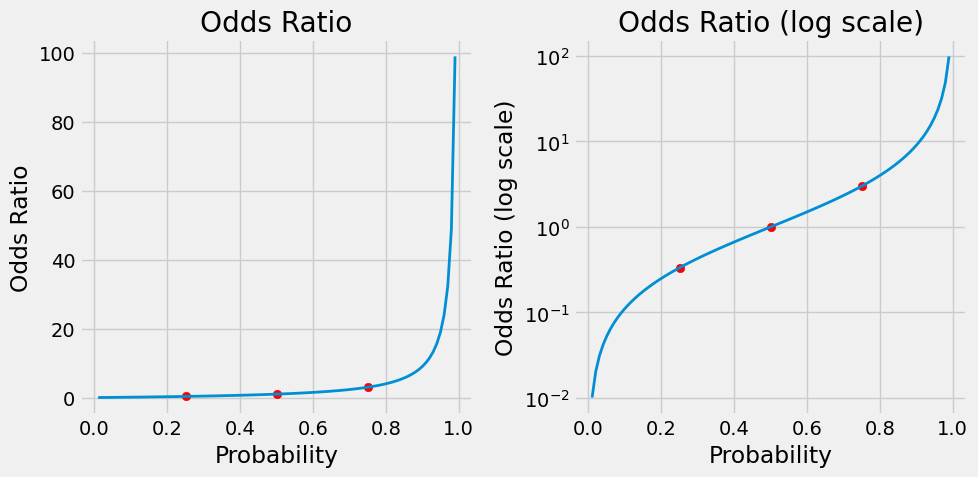

In [31]:
fig = figure2(p)

Como puede verse en las gráficas anteriores, la función correspondiente a *odds ratio* no es simétrica, pero sin embargo la del logaritmo sí lo es. Por lo tanto esto nos sugiere tomar como modelo final el siguiente

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

A la expresión $\text{log}\left(\frac{p}{1-p}\right)$ se le conoce como logit

Despejando de la fórmula anterior p, se va a obtener el siguiente valor

$$
\Large
P(y=1)=p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

que precisamente es la función sigmoidea, que utilizando código de Python.

En resumen, por z vamos a representar a los logit's, y si a este z aplicamos la función sifmoidea ($\sigma$) entonces lo pasamos a la p(y=1).

Una función para derivar esos valores, puede ser la siguiente:

In [32]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

En **Pytorch tenemos dos posibilidades** de utilizar la función sigmoidea:

* *torch.sigmoid*

* *nn.sigmoid*

De acuerdo con todo lo que hemos visto hasta ahora, se puede decir entonces que se cumple lo siguiente:

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

Es decir que la probabilidad de que y sea igual a 1 se puede ver como una composición de de dos funciones. La primera función que aplica una transformación líneal y después a la salida de esta se le aplica una transformación sigmoidea y esta sería la salida final. Este proceso se ve mejor en la siguiente figura

![clasificación](figuras/calsificacion.svg)

Ahora nos toca replicar esta idea con las herramientas que nos proporciona Pytorh. Por un lado se crea una red neuronal secuencial a la que se le añaden una transformación lineal, seguida de otra sigmoidea.

In [34]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


Con el fin de que todo lo expuesto hasta aquí, se pueda extender a cualquier conjunto de variable independientes o features, a continuación vamos a añadir una  notación matricial que además es la que se suele utilizar en temas de análisis multivariante que es el que subyace realmente a todo lo que se está exponiendo.

La representación matricial de los vectores W y X sería la siguiente:

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

El logit z definido como hemos visto anteriormente, se podría escribir de la siguiente manera

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## La función de pérdida.

```{index} binary cross-entropy, log loss, BCELoss
```

Para el problema concreto con el que nos enfrentamos, no tiene ningún sentido emplear la función de pérdida utilizada en el caso de mínimos cuadrados (análisis de regresión), ya que aquí los únicos valores de salida que obtenemos son 1 ó 0. Para este tipo de problemas, se suele emplear la función denominada **binary cross-entropy(BCE)** que también es conocida como **log loss**.

La función BCE necesita tener las probabilidades predichas devueltas por la función sigmoidea y los valores reales de *y*.Entonces vamos a armar nuestra función de pérdida siguiendo estas ideas.

* Si una observación tuviera como valor de y observado 1 (y=1), entonces sería deseable que nuestro modelo prediga que la probabilidad de que y sea 1 este muy cerca de 1, y como el logaritmo de 1 es cero, entonces el logaritmo de esa probabilidad estaría cerca de cero. Es decir:

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

* Si una observación tuviera como valor observado 0 (y=0), entonces aplicando un argumento similar al anterior se debería esperar que P(y=0) debería estar cerca de cero, y entonces 1-p(y=0) estaría cerca de uno. Por lo tanto en este caso

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

Entonces, teniendo en cuenta estas ideas la función BCE lo que hace es promediar todos estos errores e invertir el signo, es decir, sería la siguiente.

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

Otra forma más compacta de ver la expresión anterior es la siguiente.

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

La fórmula anterior, se podría trasladar a código de Pytorch de la siguiente manera (suponiendo que tenemos dos observaciones con valores de clasificación 0 y 1 y con probabilidades dadas por el modelo 0.9 y 0.2).

In [35]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])
n_total = dummy_labels.size(0)

summation = torch.sum(
dummy_labels * torch.log(dummy_predictions) +
(1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

Para ver con más claridad el sentido de la función BCE se invita al lector a ver el artículo <a href="https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a" target="_blank">Understanding binary cross-entropy / log loss: a visual explanation</a>.

Pytorch lógicamente ya tiene implementada esta <a href="https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html" target="_blank"> función de pérdida denominada **nn.BCELoss**</a>. Esta función tiene básicamente dos argumentos opcionales (los otros dos están *deprecated*):

* *reduction*: puede tomar los valores *mean, sum o none*. El valor por defecto es mean y se corresponde con la expresión que anteriormente hemos visto. La última opción, **none**, corresponde a la forma no reducida, es decir, devuelve  la matriz completa de errores.

* *weight*. Tiene un valor por defecto que es *none* y que significa que todos los puntos tienen el mismo peso.Si se informa, tiene que ser un tensor con un tamaño igual al número de elementos de un minilote (mini-batch), que representa los pesos asignados a cada elemento del lote. En otras palabras, este argumento permite asignar diferentes pesos a cada elemento del lote actual, en función de su posición. De esta manera el primer elemento tendría un peso determinado, el segundo elemento tendría un peso diferente, y así sucesivamente... independientemente de la clase real de ese punto de datos en particular. Por regla general lo que se utiliza es un peso igual a  cada observación, es decir el valor que tiene por defecto. 

El código que se utiliza para construir esta función es el siguiente

In [36]:
loss_fn = nn.BCELoss(reduction='mean')
loss_fn

BCELoss()

Como vemos nos devuelve otra función, a la que hay que pasar dos parámetros, el primero las probabilidades predichas por el modelo y de segundo los valores reales de la variable dependiente. Veamos el siguiente ejemplo, para entender mejor su uso. 

In [37]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# FORMA CORRECTA DE USO 
right_loss = loss_fn(dummy_predictions, dummy_labels)

# FORMA INCORRECTA DE USO
wrong_loss = loss_fn(dummy_labels, dummy_predictions)
print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


Hasta aquí, todo bien Y perfecto. Pero es preciso saber que hay otra función de pérdida binaria de entropía cruzada
disponible, y es muy importante saber cuándo usar una u otra, para no acabar con una combinación incoherente de
modelo y función de pérdida. Además, se entenderá por qué se he hecho tanto alboroto con los logits...

### La función de pérdida BCEWithLogitsLoss

La función de pérdida anterior, como hemos visto,  toma probabilidades como un argumento junto con los valores reales, sin embargo la función de pérdida que aquí presentamos toma como parámetro de entrada los *logits* en lugar de las probabilidades.

Todo esto significa que **NO debe añadir una función sigmoide como la última capa** de su modelo cuando se utiliza esta función de pérdida. Esta función de pérdida combina la capa  sigmoide y la anterior pérdida de entropía cruzada binaria en una sola.

En consecuencia, se tienen dos opciones.

```{note}
* **opción 1**. *nn.Sigmoid* es la última capa en la red neuronal. Entonces el modelo obtiene probabilidades y se deberá utilizar la función de pérdida *nn.BCELoss*.

* **opción 2**. La última capa no tiene *nn.Sigmoid*. Entonces el modelo estará devolviendo *logits*

Los dos modelo son válidos, ahora bien, **es preferible el segundo modelo** porque numericamente es más estable que la opción 1.
```

Los parámetros que se pueden pasar a la <a href="https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html" target="_blank"> función de pérdida nn.BCEWithLogitsLoss </a> son los siguientes:

* *reductión*. Puede tomar los valores *mean, sum o none*. El valor por defecpo es mean.

* *wight*. Similar a lo explicado para el caso de la función *nn.BCLoss*.

* *pos_weight*. el peso de las muestras positivas, debe ser un tensor con una longitud igual al número de etiquetas asociadas a un punto de datos (la documentación se refiere a las clases, en lugar de las etiquetas, lo que hace que todo sea aún más confuso).

Veamos un ejemplo de uso de esta función de pérdida

In [38]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')
loss_fn_logits

BCEWithLogitsLoss()

Como en el caso anterior, nos devuelve una función. Entonces para continuar con los datos de mini-ejemplo utilizado antes vamos a calcula los *log_odds_ratio* es decir los logits de 0.9 y 0.2 

In [39]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)
dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])
print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


Calculamos ahora la función de pérdida. Observar que con esta función de pérdida, se le pasa los log odds_ratio, no las probabilidades, como ocurría con la función de pérdida BCELoss.

In [40]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

Que es el mismo valor que el observado anteriormente.

## Datos no balanceados.

En el ejemplo de clasificación anteriormente generado, los datos están balanceados, es decir hay aproximadamente el mismo número de casos positivos que negativos, pero esta situación no  la tenemos siempre, y en bastantes ocasiones nos encontramos con un conjunto de datos no balanceados que si no son tratados previamente nos pueden dar problemas a la hora de resolver problemas de clasificación. 

Para explicar y ver de una forma práctica el comportamiento de la función *BCEWithLogitsLoss* vamos a generar un conjunto muy pequeño de datos no balanceados similar al que hemos visto en el ejemplo anterior, pero en este caso añadimos dos puntos más de tipo negativo, y entonces también añadimos dos  logits más de tipo *ligit2*. Es decir, generamos los siguientes datos 

In [41]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

Evidentemente, el anterior conjunto de datos es no balanceado puesto que hay tres datos de tipo negativo y uno solo de tipo positivo. Si recordamos cuando se ha definido *BCEWithLogitsLoss* se ha comentado que tenia un argumento denominado *pos_weight* que es el que se podría utilizar para asignar pesos y poder balancear mejor los datos. Una posible fórmula de asignación de pesos podría ser la siguiente:

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

En el caso en el que estamos trabajando, el valor sería 3. Entonces cada valor de la clase positiva sería multiplicado por esta cantidad. Entonces este valor lo podemos calcular de la siguiente manera

In [42]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()
pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

Y construiriamos la función de pérdida de la siguiente manera

In [43]:
loss_fn_imb = nn.BCEWithLogitsLoss(
reduction='mean',
pos_weight=pos_weight
)

Con lo cual se tendría el siguiente resultado

In [44]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

Pues bien, resulta que PyTorch no calcula una media ponderada. Esto es lo que se espera de una media ponderada:

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

Pero sin embargo, lo que calcula Pytorch es lo siguiente

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

Entonces para utilizar la fórmula anterior para un función de pérdida, se puede hacer los siguiente. Con el siguiente código se puede calcular el numerador de la última fórmula anterior

In [45]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(
reduction='sum',
pos_weight=pos_weight
)

Y ahora teniendo en cuenta el denominador, se calcularía definitivamente así

In [46]:
loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)
loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Configuración del modelo.

En este apartado sólo necesitamos definir un modelo, una función de pérdida adecuada y un optimizador. Definiremos un modelo que produzca logits y utilicemos BCEWithLogitsLoss como función de pérdida.

Como tenemos dos características y estamos produciendo logits en lugar de probabilidades, nuestro modelo tiene  una sola capa: Lineal(2, 1). Seguiremos utilizando el optimizador SGD con una tasa de aprendizaje de 0,1 por ahora.

Entonces nuestro modelo quedaría configurado de la siguiente manera

In [47]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Entrenamiento del modelo

Utilizaremos para esto la clase ya definida en el capítulo anterior que se llamaba *StepByStep*

In [48]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

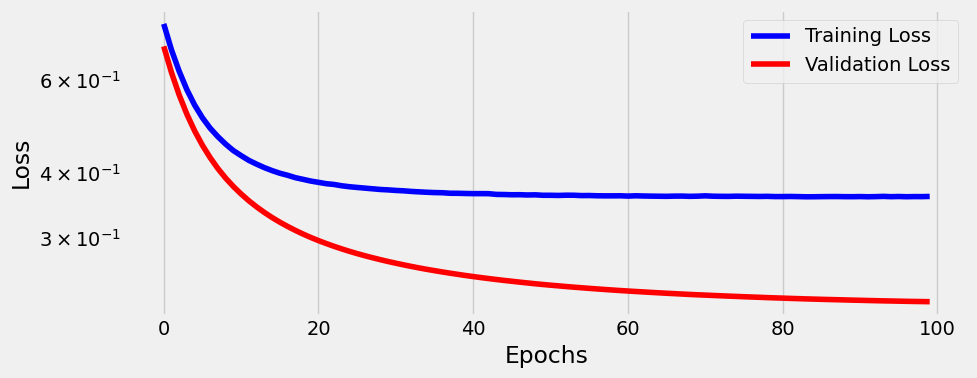

In [49]:
fig = sbs.plot_losses()

Observamos en el gráfico anterior algo importante a tener en cuenta.La curva de  la pérdida de validación es menor que la pérdida de entrenamiento. ¿No debería ser al revés? Bueno, en general, SÍ, debería... pero puedes aprender más sobre situaciones en las que este este intercambio en <a href="https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/" target="_blank"> este interesante post </a>. 

En nuestro caso, simplemente se dio el caso de que el conjunto de validación es más fácil de clasificar, y se puede ver en los gráficos iniciales que hemos sacado al principio sobre la distribución de los puntos de prueba y los de entrenamiento: si se mira en esa Figura, al principio del capítulo, observará que los puntos rojo y azul en el gráfico de la derecha (validación) no están tan mezclados como los de la izquierda (entrenamiento). Por ese motivo discrimina mucho mejor en los datos de validación y ese será el motivo de que la función de perdida es menor para estos puntos.

In [50]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1815, -1.8690]], device='cuda:0')), ('linear.bias', tensor([-0.0581], device='cuda:0'))])


Con esta salida lo que obtenemos son los logits, que serán los siguientes

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

Veamos ahora cómo hariamos la predicción de los cuatro primeros puntos de conjunto de entrenamiento

In [51]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.2038224],
       [ 2.9454765],
       [ 3.6952524],
       [-1.2338293]], dtype=float32)

Los resultado anteriores, claramente  no son probabilidades, son los logits. Para calcular las probabilidades, tenemos que aplicar a los logits la función sigmoidea y por lo tanto debemos ejecutar lo siguiente:

In [52]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5507799 ],
       [0.9500492 ],
       [0.97576094],
       [0.22551191]], dtype=float32)

Por último, hay que pasar de las probabilidades a las clases. Si la probabilidad es mayor o igual que un umbral, es un ejemplo de clase positiva. Si es menor que el umbral, es un ejemplo negativo. En principio la elección de ese umbral puede ser o.5, pero esta cuestión depende de otros factores que más adelante veremos.

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

Pero la probabilidad en sí no es más que la función sigmoidea aplicada al logit(z), por lo tanto:

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

Pero la función sigmoidea tiene un valor de 0,5 sólo cuando el logit(z) tiene un valor de cero, y en consecuencia:

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

Por lo tanto, si no nos importan las probabilidades, podríamos utilizar las predicciones (logits) directamente para obtener las clases predichas para los puntos de datos:

In [53]:
classes = (predictions >= 0).astype(np.int)
classes

C:\Users\Francisco\AppData\Local\Temp\ipykernel_8364\171441995.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  classes = (predictions >= 0).astype(np.int)


array([[1],
       [1],
       [1],
       [0]])

Claramente, los puntos donde los logits (es decir los valores que hemos designado con z) son iguales a cero determinan la límite entre los ejemplos positivos y negativos.

Lo que sí podemos decir es que diferentes umbrales (thresholds) le darán diferentes matrices de confusión y, por tanto, diferentes métricas, como accuracy, precisión y recall. Volveremos a hablar de ello en la siguiente sección.

## Decisión Boundary.

```{index} Decision Boundary
```

Anteriormente se ha dicho que creabamos una frontera de decisión (decision boundary) haciendo z=0, veamos lo que esto significa.

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

Es decir y de acuerdo con el resultado anterior, el valor de x2 quedará fijado por el valor que demos a x1, y así de esta manera podemos calcular la frontera de decisión. La anterior expresión genérica, para el problema que estamos abordando, nos daría lo siguiente:

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

Vamos a sacar para este ejemplo la matriz de confusión

In [54]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()

cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]], dtype=int64)

En la siguiente figura se muestra cómo es el formato de salida de una matriz de confusión en scikit learn

![Matriz confusión](figuras/matrizConfusion.PNG)

Vamos a definir a continuación una función que toma como argumento la matriz de confusión obtenida con scikit learn y de ella vamos a extraer los cuatro elementos 

In [102]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

De los datos obtenidos en una matriz de confusión se suelen extaer diferentes métricas que pretenden estudiar la bondad del ajuste desde distintos puntos de vista. A continuación se pasan a exponer estas métricas.

## Razón de True y False positivos.

Se definen de la siguiente manera.

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

Vamos a definir nosotros una función que nos permita calcular estas tasas de forma automática, una vez conozcamos la matriz de confusión.

In [103]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [104]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

## Precision y Recall.

Son otras dos medidas muy interesantes en los problemas de clasificación. Se definen de la siguiente manera.

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

La función que nos permite obtener estos valores, se puede construir de la siguiente manera

In [105]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [106]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

## Acuracidad.

```{index} curva de ROC, curva precision-recall
```

Con esta medida se calcula el porcentaje de aciertos del algoritmo. Se define por lo tanto de la siguiente manera

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

Como podemos observar en todas las fórmulas expuestas anteriormente existe una relación entre TPR y FPR así como entre los valores de precison y recall. También hay que tener en cuenta que si se modifica el punto de corte o threshold también cambia la matriz de confusión y por tanto los indicadores anteriormente presentados. POr lo tanto, si se modifica el punto de corte entre 0 y 1 se tendrán una serie de pares de valores (FPR,TPR) y (Recall,precision). Si ponemos el primer conjunto de puntos en unos ejes coordenados, se obtendrá la denominada *curva de ROC*, mientras que si graficamos el segundo conjunto de puntos, se obtendrá el gráfico denominado *Curva Precision-Recall*.

Si tenemos en cuenta los puntos de TPR, FPR, precision y recall obtenidos para el punto de corte 0.5 y los ponemos en los gráficos comentados anteriormente, se obtendría lo siguiente.

![Curva ROC](figuras/ROC.PNG)

Lo anterior se obtiene para un punto de corte prefijado. Si ahora hacemos variar este punto de corte obtendríamos nuevos puntos que configurarán las curva de ROC y de preciso-recall.

Veamos qué valores obtenemos para un punto de corte de 0.3

In [107]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]], dtype=int64)

In [108]:
# Para un valor 0.7
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]], dtype=int64)

Al final si vamos moviendo estos puntos de corte entre 0 y 1 obtendríamos las dos gráficas que se muestran a continuación

![Curvas de ROC](figuras/ROC2.PNG)

